# Missing outputs

## What is Missing Outputs?

Sometimes, certain outputs (e.g., power at some `k`s) are not observed for some data points. Despite this, we can still train an `SVGP` model using the `LinearCoregionalization` kernel. This kernel distills information from the observed outputs to predict the missing ones. The key features are:

1. Each output dimension can have inputs at arbitrary locations, i.e., the input array `X` can differ across outputs.
2. Some outputs can be missing for specific `X` values, represented as `NaN`.
3. Likliehood has independant trainable variance for each output dimension.

## How to Handle Missing Values?

We define a custom likelihood, `MaskedGaussian`, which implements the `_variational_expectations()` method. This method masks `NaN` values before computing the variational expectations.

> Note: This likelihood is designed for variational inference (`SVGP`). For the non-variational case (`VGP`), refer to the GPflow documentation:  
> https://gpflow.github.io/GPflow/2.4.0/notebooks/advanced/coregionalisation.html


## The implementation:

In [ ]:
import gpflow
import tensorflow as tf

import numpy as np
from gpflow.kernels import Matern32, RBF
from gpflow.kernels.multioutput import LinearCoregionalization
from gpflow.inducing_variables import SharedIndependentInducingVariables, InducingPoints
from gpflow.models import SVGP

# NOTE: WE have to set the default float to tf.float64
# to avoid dtype mismatches in the model.
gpflow.config.set_default_float(tf.float32)


class MaskedGaussian(gpflow.likelihoods.Gaussian):
    """
    Gaussian likelihood that ignores NaN entries in Y
    when computing the variational expectations.
    
    This is specifically for SVGP/VGP training, 
    where _variational_expectations is used in the ELBO.
    
    Y and Fmu, Fvar shapes: [N, P].
    """
    def _variational_expectations(self, X, Fmu, Fvar, Y):
        # Create a mask for non-NaN entries
        # Ensure dtype consistency
        Y = tf.cast(Y, Fmu.dtype)
        self.variance = tf.cast(self.variance, Fmu.dtype)
        mask = ~tf.math.is_nan(Y)
        # Fill missing outputs with zero so that they don't contribute
        # to the squared difference. Alternatively, you could do a boolean_mask
        Y_filled = tf.where(mask, Y, tf.zeros_like(Y))
        Fmu_filled = tf.where(mask, Fmu, tf.zeros_like(Fmu))
        Fvar_filled = tf.where(mask, Fvar, tf.zeros_like(Fvar))
        # The standard closed-form expression for VE under a Gaussian likelihood
        # shape [N, P]
        ve = -0.5 * tf.math.log(2.0 * np.pi) \
             - 0.5 * tf.math.log(self.variance) \
             - 0.5 * ((Y_filled - Fmu_filled) ** 2 + Fvar_filled) / self.variance

        # Now we want to zero out the VE for missing entries.
        # If an entry is masked, set ve to 0 there:
        ve_masked = tf.where(mask, ve, tf.zeros_like(ve))

        # ve_masked is of shape: [N, P]
        # Sum over the output dimensions to yield a [N] tensor.
        return tf.reduce_sum(ve_masked, axis=-1)

    # Optional: also override `_predict_log_density` if you want masked predictions
    # def _predict_log_density(self, Fmu, Fvar, Y):
    #     ...


class MultiOutputGPWithMaskedLikelihood:
    def __init__(self, X, Y, mean_func, num_latent=2, num_inducing=10):
        """
        X: [N, D] input
        Y: [N, P] outputs (some entries of Y can be NaN)
        num_latent: number of latent GPs
        num_inducing: size of the inducing point set
        """
        # ----- 1) Define latent kernels (one per latent GP) -----
        latent_kernels = [Matern32(), RBF()]

        # ----- 2) Combine into an LMC kernel -----
        #    - Suppose we have P outputs (Y.shape[1])
        #    - We'll mix the Q latent GPs via a W matrix of shape (P, Q)
        P = Y.shape[1]
        W_init = np.random.randn(P, num_latent) * 0.1
        W_init = W_init.astype(np.float32)

        self.kernel = LinearCoregionalization(
            kernels=latent_kernels,
            W = W_init
        )

        # ----- 3) Define a custom masked Gaussian likelihood -----
        # Here we create a vector of variances, one for each output dimension.
        self.likelihood = MaskedGaussian(variance=np.ones((Y.shape[1],), dtype=np.float32))

        # ----- 4) Construct the SVGP model -----
        Zinit = np.linspace(np.min(X), np.max(X), num_inducing).reshape(-1, 1)
        Zinit = Zinit.astype(np.float64)
        inducing_variable = SharedIndependentInducingVariables(InducingPoints(Zinit))

        # We need num_latent_gps = number of latent GPs in LMC (same as len(latent_kernels))
        self.model = SVGP(
            kernel=self.kernel,
            likelihood=self.likelihood,
            inducing_variable=inducing_variable,
            num_latent_gps=num_latent,
            num_data=X.shape[0],
            mean_function=mean_function
        )

        # Keep track of losses
        self.loss_history = []


    def elbo(self, data):
        X, Y = data
        return self.model.elbo((X, Y))  # uses self.likelihood internally

    def optimize(self, data, max_iters=1000, initial_lr=0.01, unfix_noise_after=0):
        """
        data: (X, Y) where Y can have NaNs representing missing outputs.
        """
        X, Y = data

        # Warm up the TFP cache by calling elbo once outside the tf.function.
        _ = self.model.elbo((X, Y))
        
        # Create the optimizer with a cosine decay schedule.
        schedule = tf.keras.optimizers.schedules.CosineDecay(initial_lr, max_iters)
        optimizer = tf.optimizers.Adam(schedule)

        # Define a reusable tf.function that accepts X and Y as arguments.
        @tf.function
        def optimization_step(X, Y):
            with tf.GradientTape() as tape:
                loss = -self.model.elbo((X, Y))
            grads = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            return loss

        # Run the optimization loop, reusing the same tf.function.
        for i in range(max_iters):
            loss = optimization_step(X, Y)
            self.loss_history.append(loss.numpy())

            # Optionally, set the likelihood's noise variance to be trainable at a given iteration.
            if i == unfix_noise_after:
                self.likelihood.variance[i].trainable = True


            # if i % 100 == 0:
            #     print(f"Iteration {i}, ELBO = {-loss.numpy()}")
        
        # Final model is in self.model
        # self.likelihood is being used automatically in the model's ELBO




2025-04-10 09:56:09.635273: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 09:56:09.638700: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 09:56:09.649137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744296969.665579  283004 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744296969.670431  283004 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 09:56:09.687519: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Demo for a simple test case:

In [2]:

def mean_function(X):
    """
    Example mean function: constant mean.
    """
    X = tf.convert_to_tensor(X, dtype=tf.float64)
    return tf.zeros((X.shape[0], 1), dtype=X.dtype)



# make a dataset with two outputs, correlated, heavy-tail noise. One has more noise than the other.
X1 = np.random.rand(100, 1)  # Observed locations for first output
X2 = np.random.rand(50, 1)  # Observed locations for second output
X3 = np.random.rand(50, 1) * 0.5 # Observed locations for third output
X = np.vstack([X1, X2, X3])  # Combine observed locations
Y = np.full((X.shape[0], 3), np.nan)  # Initialize Y with NaNs

Y[0:X1.shape[0], 0] = 2 +(np.sin(6 * X1) + np.random.randn(*X1.shape) * 0.03).squeeze()
Y[X1.shape[0]:X1.shape[0]+X2.shape[0], 1] = 2 + (np.sin(6 * X2 + 0.7) + np.random.randn(*X2.shape) * 0.1).squeeze()
Y[X1.shape[0]+X2.shape[0]:, 2] = 2 + (np.sin(6 * X3 - 0.7) + np.random.randn(*X3.shape) * 0.1).squeeze()


X_float32 = X.astype(np.float32)
Y_float32 = Y.astype(np.float32)
print(X_float32.shape, Y_float32.shape)

# Build and optimize
gpmodel = MultiOutputGPWithMaskedLikelihood(X_float32, Y_float32, mean_func=mean_function)
gpmodel.optimize((X_float32, Y_float32), max_iters=5000, initial_lr=0.01)

final_elbo = gpmodel.elbo((X_float32, Y_float32))
print("Final ELBO =", final_elbo.numpy())

(200, 1) (200, 3)


2025-04-10 09:56:13.008720: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Instructions for updating:
Use fn_output_signature instead
Final ELBO = -201.84521


(200, 3) (200, 3)


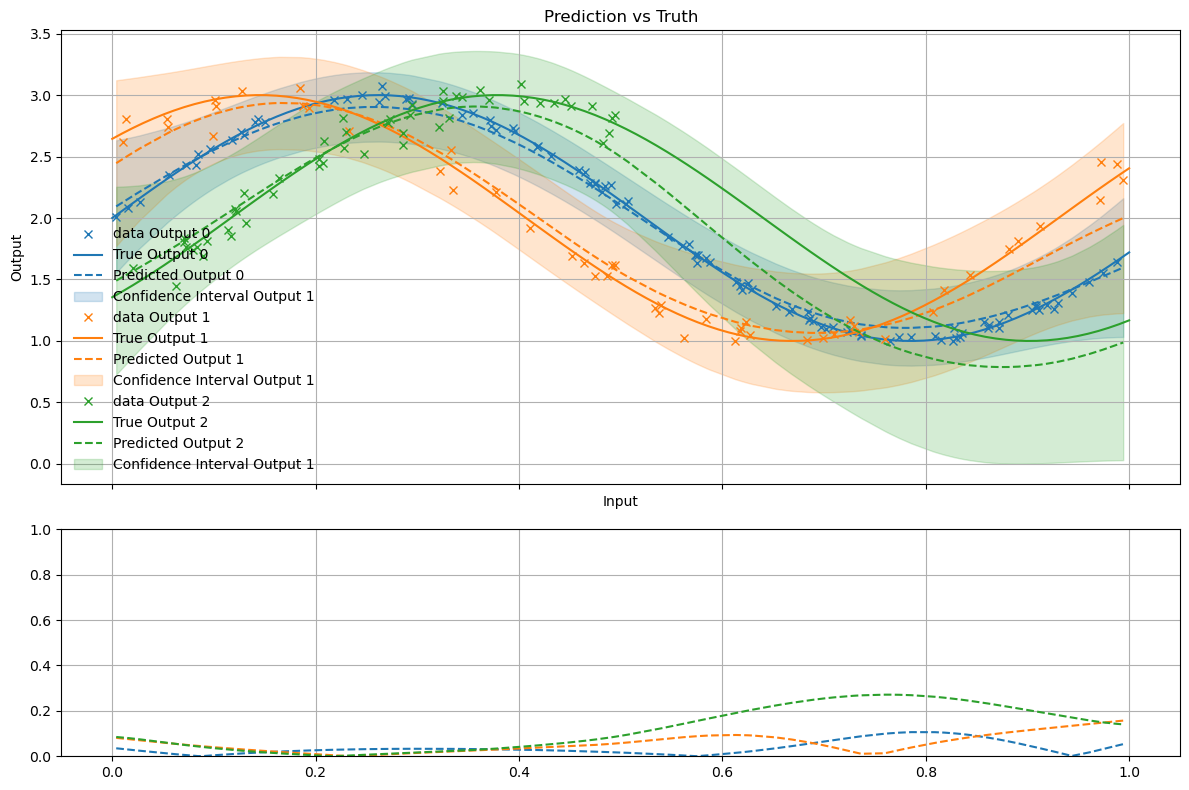

In [3]:
import matplotlib.pyplot as plt
# Generate predictions



def true_func(x_val):
    y_true = np.zeros((x_val.shape[0], 3))
    y_true[:, 0] = 2+(np.sin(6 * x_val)).squeeze()
    y_true[:, 1] = 2 +(np.sin(6 * x_val + 0.7)).squeeze()
    y_true[:, 2] = 2+(np.sin(6 * x_val- 0.7)).squeeze()
    return y_true
x_fine = np.linspace(0,1, 100)
Y_true = true_func(x_fine)
ind_sorted = np.argsort(X[:, 0])
X = X[ind_sorted]
Y = Y[ind_sorted]
mean_pred, var_pred = gpmodel.model.predict_f(X)

print(mean_pred.shape, var_pred.shape)


# Plot predictions vs truth

fig, ax = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
for i in range(Y.shape[1]):
    ax[0].plot(X, Y[:, i], 'x', label=f"data Output {i}", color=f"C{i}")
    ax[0].plot(x_fine, Y_true[:, i], label=f"True Output {i}", color=f"C{i}")
    ax[0].plot(X, mean_pred[:, i], label=f"Predicted Output {i}", color=f"C{i}", ls="--")
    ax[0].fill_between(
        X.flatten(),
        mean_pred[:, i] - 2 * np.sqrt(var_pred[:, i]),
        mean_pred[:, i] + 2 * np.sqrt(var_pred[:, i]),
        alpha=0.2,label="Confidence Interval Output 1", color=f"C{i}"
    )
    ax[1].plot(X, np.abs(mean_pred[:,i]/true_func(X)[:,i]-1), label=f"Predicted Output {i}", color=f"C{i}", ls="--")



ax[0].set_xlabel("Input")
ax[0].set_ylabel("Output")
ax[0].legend(framealpha=0)
ax[0].set_title("Prediction vs Truth")
ax[0].grid(True)

ax[1].set_ylim(0, 1)
ax[1].grid(True)
fig.tight_layout()


Look how well it does for the green curve despite missing all outputs above x>0.5.

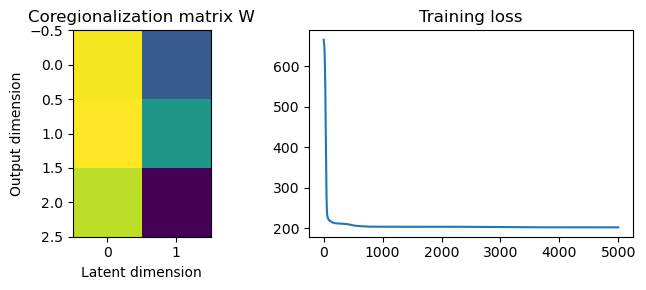

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].imshow(gpmodel.model.kernel.W.numpy())
ax[1].plot(gpmodel.loss_history)
ax[0].set_title("Coregionalization matrix W")
ax[0].set_xlabel("Latent dimension")
ax[0].set_ylabel("Output dimension")

ax[1].set_title("Training loss")
fig.tight_layout()

## Arbitrary Uncertainty for Each Data Point

An alternative to treating outputs as missing is to assign large error bars (i.e., high uncertainty) to those data points. To handle this, we define a new likelihood, `HeteroscedasticGaussian`, with a custom `_variational_expectations()` method that accepts `Y_unc` (uncertainty) for each data point.

This results in an "effective variance" per data point, computed as the sum of the trainable likelihood variance and the input uncertainties:

```python
# Compute the effective noise variance per data point and output.
effective_variance = self.variance + Y_unc  # [N, P]


In [1]:
import gpflow
import tensorflow as tf

import numpy as np
from gpflow.kernels import Matern32, RBF
from gpflow.kernels.multioutput import LinearCoregionalization
from gpflow.inducing_variables import SharedIndependentInducingVariables, InducingPoints
from gpflow.models import SVGP

# NOTE: WE have to set the default float to tf.float32
# to avoid dtype mismatches in the model.
gpflow.config.set_default_float(tf.float32)

class HeteroscedasticGaussian(gpflow.likelihoods.Gaussian):
    """
    Gaussian likelihood that incorporates a per-data-point uncertainty for each output.
    
    Instead of passing a tuple, this implementation expects the targets to be a combined tensor:
    
         Y_combined = [Y_obs, Y_unc]
         
    concatenated along the last dimension, so that if Y_obs and Y_unc are each shape [N, P],
    then Y_combined has shape [N, 2*P]. In this likelihood, the effective noise variance is:
    
         effective_variance = self.variance + Y_unc
         
    where self.variance is a (possibly vector-valued) baseline noise parameter.
    """
    def _variational_expectations(self, X, Fmu, Fvar, Y):
        # Fmu and Fvar have shape [N, P] where P is the number of outputs.
        # Y is assumed to have shape [N, 2*P], with the first P columns for Y_obs and the next P for Y_unc.
        P = tf.shape(Fmu)[-1]
        Y_obs = Y[:, :P]
        Y_unc = Y[:, P:]
        
        # Cast to correct type.
        Y_obs = tf.cast(Y_obs, Fmu.dtype)
        Y_unc = tf.cast(Y_unc, Fmu.dtype)
        self.variance = tf.cast(self.variance, Fmu.dtype)
        
        # Compute the effective noise variance per data point and output.
        effective_variance = self.variance + Y_unc  # [N, P]
        
        # Standard variational expectations of a Gaussian likelihood:
        ve = -0.5 * tf.math.log(2.0 * np.pi) \
             - 0.5 * tf.math.log(effective_variance) \
             - 0.5 * ((Y_obs - Fmu) ** 2 + Fvar) / effective_variance
        
        # Sum over outputs to produce a [N]-shaped tensor.
        return tf.reduce_sum(ve, axis=-1)

class MultiOutputGPWithMaskedLikelihood:
    def __init__(self, X, Y, num_latent=2, num_inducing=10):
        """
        X: [N, D] input
        Y: [N, P] outputs (some entries of Y can be NaN)
        num_latent: number of latent GPs
        num_inducing: size of the inducing point set
        """
        # ----- 1) Define latent kernels (one per latent GP) -----
        latent_kernels = [Matern32(), RBF()]

        # ----- 2) Combine into an LMC kernel -----
        #    - Suppose we have P outputs (Y.shape[1])
        #    - We'll mix the Q latent GPs via a W matrix of shape (P, Q)
        P = Y.shape[1]
        #W_init = initialize_W(P, num_latent, window_fraction=0.4, scale=0.2)
        W_init = np.random.randn(P, num_latent) * 0.1
        W_init = W_init.astype(np.float32)

        self.kernel = LinearCoregionalization(
            kernels=latent_kernels,
            W = W_init
        )

        # ----- 3) Define a custom masked Gaussian likelihood -----
        # Use HeteroscedasticGaussian.
        # Here we initialize a separate baseline noise variance for each output.
        self.likelihood = HeteroscedasticGaussian(variance=np.ones((Y.shape[1],), dtype=np.float32))


        # ----- 4) Construct the SVGP model -----
        Zinit = np.linspace(np.min(X), np.max(X), num_inducing).reshape(-1, 1)
        Zinit = Zinit.astype(np.float32)
        inducing_variable = SharedIndependentInducingVariables(InducingPoints(Zinit))

        # We need num_latent_gps = number of latent GPs in LMC (same as len(latent_kernels))
        self.model = SVGP(
            kernel=self.kernel,
            likelihood=self.likelihood,
            inducing_variable=inducing_variable,
            num_latent_gps=num_latent,
            num_data=X.shape[0],
            mean_function=mean_function
        )

        # Keep track of losses
        self.loss_history = []


    def elbo(self, data):
        X, Y = data
        return self.model.elbo((X, Y))  # uses self.likelihood internally

    def optimize(self, data, max_iters=1000, initial_lr=0.01, unfix_noise_after=0):
        """
        data: (X, Y) where Y is (Y_obs, Y_unc) concatenated along the last dimension.
        Y_obs: observed outputs
        Y_unc: uncertainty estimates for each output
        """
        X, Y = data

        # Warm up the TFP cache by calling elbo once outside the tf.function.
        _ = self.model.elbo((X, Y))
        
        # Create the optimizer with a cosine decay schedule.
        schedule = tf.keras.optimizers.schedules.CosineDecay(initial_lr, max_iters)
        optimizer = tf.optimizers.Adam(schedule)

        # Define a reusable tf.function that accepts X and Y as arguments.
        @tf.function
        def optimization_step(X, Y):
            with tf.GradientTape() as tape:
                loss = -self.model.elbo((X, Y))
            grads = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            return loss

        # Run the optimization loop, reusing the same tf.function.
        for i in range(max_iters):
            loss = optimization_step(X, Y)
            self.loss_history.append(loss.numpy())

            # Optionally, set the likelihood's noise variance to be trainable at a given iteration.
            if i == unfix_noise_after:
                for j in range(int(Y.shape[1]/2)):
                    self.likelihood.variance[j].trainable = True


            # if i % 100 == 0:
            #     print(f"Iteration {i}, ELBO = {-loss.numpy()}")
        
        # Final model is in self.model
        # self.likelihood is being used automatically in the model's ELBO




2025-04-10 14:23:01.896345: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 14:23:01.899551: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 14:23:01.909557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744312981.926371  300547 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744312981.931319  300547 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 14:23:01.949032: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

#### Applying on the test dataset:

In [2]:
def mean_function(X):
    """
    Example mean function: constant mean.
    """
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    return tf.zeros((X.shape[0], 1), dtype=X.dtype)

# make a dataset with two outputs, correlated, heavy-tail noise. One has more noise than the other.
X1 = np.random.rand(100, 1)  # Observed locations for first output
X2 = np.random.rand(50, 1)  # Observed locations for second output
X3 = np.random.rand(50, 1) * 0.5 # Observed locations for third output
X = np.vstack([X1, X2, X3])  # Combine observed locations
Y = np.full((X.shape[0], 3), np.nan)  # Initialize Y with NaNs

Y[0:X1.shape[0], 0] = 2 +(np.sin(6 * X1) + np.random.randn(*X1.shape) * 0.03).squeeze()
Y[X1.shape[0]:X1.shape[0]+X2.shape[0], 1] = 2 + (np.sin(6 * X2 + 0.7) + np.random.randn(*X2.shape) * 0.1).squeeze()
Y[X1.shape[0]+X2.shape[0]:, 2] =2 + (np.sin(6 * X3 - 0.7) + np.random.randn(*X3.shape) * 0.1).squeeze()




X_float32 = X.astype(np.float32)
Y_float32 = Y.astype(np.float32)
print(X_float32.shape, Y_float32.shape)

# For demonstration, let’s assume a constant uncertainty (or you can supply your own)
Y_unc = 0.01 * np.ones_like(Y_float32)  # [N, P] uncertainties
mask_nan = np.isnan(Y_float32)
# Assign large uncertainty to NaN entries
Y_unc[mask_nan] = 1e6  # or some other large value
Y_float32[mask_nan] = 0.0  # or some other value

# Suppose Y_float32 is your Y_obs and Y_unc is your uncertainty array.
# For instance:
Y_combined = np.concatenate([Y_float32, Y_unc], axis=1)  # shape becomes [N, 2*P]

# Build and optimize
gpmodel = MultiOutputGPWithMaskedLikelihood(X_float32, Y_float32)  # Note: here Y_float32 is used only to determine P.
gpmodel.optimize((X_float32, Y_combined), max_iters=5000, initial_lr=0.01)

final_elbo = gpmodel.elbo((X_float32, Y_combined))
print("Final ELBO =", final_elbo.numpy())

(200, 1) (200, 3)


2025-04-10 14:23:05.204384: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Instructions for updating:
Use fn_output_signature instead
Final ELBO = -3333.3843


(200, 3) (200, 3)


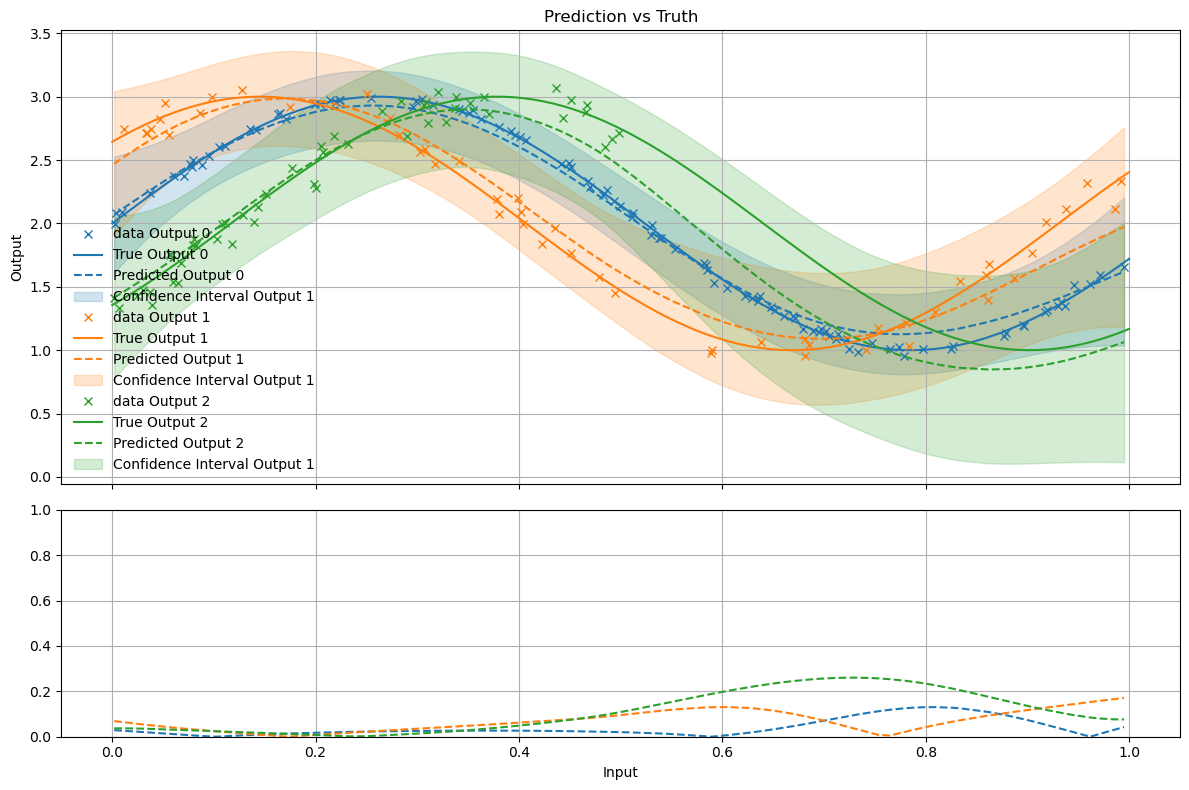

In [3]:
import matplotlib.pyplot as plt
# Generate predictions



def true_func(x_val):
    y_true = np.zeros((x_val.shape[0], 3))
    y_true[:, 0] = 2+(np.sin(6 * x_val)).squeeze()
    y_true[:, 1] = 2 +(np.sin(6 * x_val + 0.7)).squeeze()
    y_true[:, 2] = 2+(np.sin(6 * x_val- 0.7)).squeeze()
    return y_true
x_fine = np.linspace(0,1, 100)
Y_true = true_func(x_fine)
ind_sorted = np.argsort(X[:, 0])
X = X[ind_sorted]
Y = Y[ind_sorted]
mean_pred, var_pred = gpmodel.model.predict_f(X)

print(mean_pred.shape, var_pred.shape)


# Plot predictions vs truth

fig, ax = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
for i in range(Y.shape[1]):
    ax[0].plot(X, Y[:, i], 'x', label=f"data Output {i}", color=f"C{i}")
    ax[0].plot(x_fine, Y_true[:, i], label=f"True Output {i}", color=f"C{i}")
    ax[0].plot(X, mean_pred[:, i], label=f"Predicted Output {i}", color=f"C{i}", ls="--")
    ax[0].fill_between(
        X.flatten(),
        mean_pred[:, i] - 2 * np.sqrt(var_pred[:, i]),
        mean_pred[:, i] + 2 * np.sqrt(var_pred[:, i]),
        alpha=0.2,label="Confidence Interval Output 1", color=f"C{i}"
    )
    ax[1].plot(X, np.abs(mean_pred[:,i]/true_func(X)[:,i]-1), label=f"Predicted Output {i}", color=f"C{i}", ls="--")



ax[1].set_xlabel("Input")
ax[0].set_ylabel("Output")
ax[0].legend(framealpha=0)
ax[0].set_title("Prediction vs Truth")
ax[0].grid(True)

ax[1].set_ylim(0, 1)
ax[1].grid(True)
fig.tight_layout()


So the performance is similar to the `MaskedGaussian` likliehood!

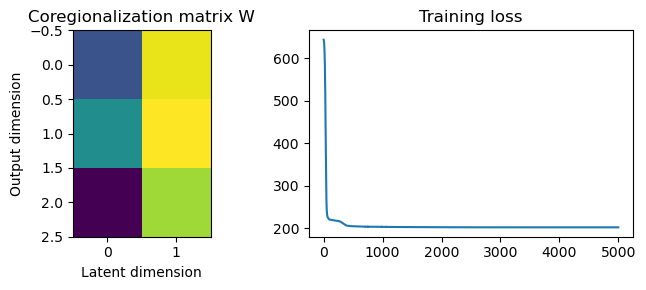

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].imshow(gpmodel.model.kernel.W.numpy())
ax[1].plot(gpmodel.loss_history)
ax[0].set_title("Coregionalization matrix W")
ax[0].set_xlabel("Latent dimension")
ax[0].set_ylabel("Output dimension")

ax[1].set_title("Training loss")
fig.tight_layout()

### Applying the Multifidelity Kernel

The multifidelity kernel implemented in `linear_svgp.LatentMFCoregionalizationSVGP` can incorporate uncertainties associated with training data. To enable this feature, set the parameter `heterosed=True` and format your output data as `Y = (Y, Y_unc)`.

In the following example, we illustrate this capability using the dataset from the notebook `demo: matter power latent inference.ipynb`. We assign very small uncertainties to demonstrate that the model converges to the original results when data uncertainties are negligible.


2025-04-20 19:28:50.106192: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 19:28:50.109078: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 19:28:50.118875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745195330.135037 1193676 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745195330.139838 1193676 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-20 19:28:50.156721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Text(0, 0.5, '$P_{k}$')

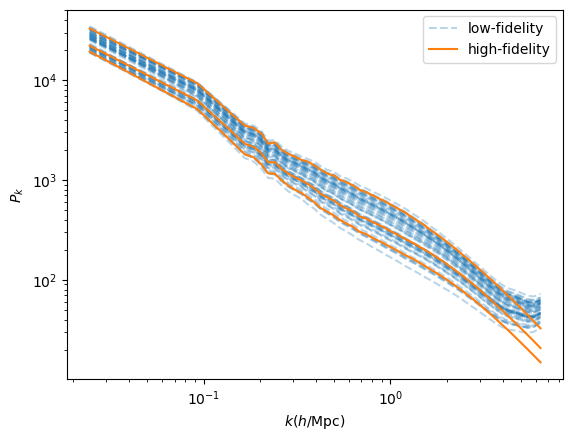

In [1]:
import numpy as np

from matplotlib import pyplot as plt

import gpflow

import sys
sys.path.append('../')

from mfgpflow.data_loader import PowerSpecs
from mfgpflow.linear import MultiFidelityGPModel

def generate_data(folder: str = "data/50_LR_3_HR"):
    data = PowerSpecs()
    data.read_from_txt(folder=folder)
    return data

data = generate_data("../data/50_LR_3_HR")


# visualize training spectra
for i,y_train in enumerate(data.Y_train[0]):
    if i == 0:
        plt.loglog(10**data.kf, 10**y_train, label="low-fidelity", color="C0", ls='--', alpha=0.3)
    else:
        plt.loglog(10**data.kf, 10**y_train, color="C0", ls='--', alpha=0.3)
for i,y_train in enumerate(data.Y_train[1]):
    if i == 0:
        plt.loglog(10**data.kf, 10**y_train, label="high-fidelity", color="C1")
    else:
        plt.loglog(10**data.kf, 10**y_train, color="C1")
plt.legend()
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k}$")


In [2]:
from mfgpflow.linear_svgp import LatentMFCoregionalizationSVGP

In [3]:
import numpy as np
import gpflow
import tensorflow as tf
from sklearn.cluster import KMeans

gpflow.config.set_default_float(tf.float64)

# 🔹 1️⃣ Load Data
X_LF, Y_LF = data.X_train_norm[0], data.Y_train_norm[0]  # LF Data (50, 5) → (50, 49)
X_HF, Y_HF = data.X_train_norm[1], data.Y_train_norm[1]  # HF Data (3, 5) → (3, 49)
X_test_HF, Y_test_HF = data.X_test_norm[0], data.Y_test[0]  # Test HF Data (10, 5) → (10, 49)

# 🔹 2️⃣ Prepare Training Data
n_LF, n_HF = X_LF.shape[0], X_HF.shape[0]  # Number of points
output_dim = Y_LF.shape[1]  # 49 output dimensions
num_latents = 15  # Reduce latent GPs to match HF sparsity
num_inducing = 50  # Reduce inducing points to prevent overfitting

# ✅ Append fidelity indicators (0 for LF, 1 for HF)
X_LF_aug = np.hstack([X_LF, np.zeros((n_LF, 1))])  # LF data with fidelity=0
X_HF_aug = np.hstack([X_HF, np.ones((n_HF, 1))])   # HF data with fidelity=1

# ✅ Combine datasets
X_train = np.vstack([X_LF_aug, X_HF_aug])  # Shape: (53, 6)
Y_train = np.vstack([Y_LF, Y_HF])  # Shape: (53, 49)

# 🔹 3️⃣ Define Multi-Fidelity GP Model
# ✅ Define base kernels for LF and HF discrepancy
kernel_L = gpflow.kernels.SquaredExponential(lengthscales=np.ones(5, dtype=np.float64), variance=np.float64(1.0))
kernel_delta = gpflow.kernels.SquaredExponential(lengthscales=np.ones(5, dtype=np.float64), variance=np.float64(1.0))

# ✅ Mixed Kernel (SE + Linear) to capture smooth & linear trends
kern_list = [gpflow.kernels.SquaredExponential() for _ in range(num_latents)]


X_train = X_train.astype(np.float64)
Y_train = Y_train.astype(np.float64)
# ✅ Initialize the Latent Multi-Fidelity Coregionalization SVGP model
mf_gp = LatentMFCoregionalizationSVGP(
    X_train, Y_train, kernel_L, kernel_delta,
    num_outputs=output_dim, num_latents=num_latents, 
    num_inducing=num_inducing, heterosed=True)

Y_unc = np.ones_like(Y_train) * 1e-6  # Assign super small uncertainties


Y_combined = np.concatenate([Y_train, Y_unc], axis=1).astype(np.float64)  # shape becomes [N, 2*P]

print(f'X_train shape: {X_train.shape}, Y_combined shape: {Y_combined.shape}, num_latents: {num_latents}, num_inducing: {num_inducing}')

# 🔹 4️⃣ Train the Model with Adaptive Learning Rate
mf_gp.optimize(
    (X_train, Y_combined),
    max_iters=2000,  # Reduce training iterations
    initial_lr=0.01,  # Lower learning rate for stability
    unfix_noise_after=500,  # Delay unfixing noise variance
)

# 🔹 5️⃣ Make Predictions on HF Test Set
X_test_HF_aug = np.hstack([X_test_HF, np.ones((10, 1))])  # Add HF indicator (1)
X_test_HF_aug = X_test_HF_aug.astype(np.float64)  # Ensure correct dtype
mean_pred, var_pred = mf_gp.predict_f(X_test_HF_aug)



2025-04-20 19:28:56.324295: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


X_train shape: (53, 6), Y_combined shape: (53, 98), num_latents: 15, num_inducing: 50
Instructions for updating:
Use fn_output_signature instead
🔹 Iteration 0: ELBO = 3008.9025623999833
🔹 Iteration 100: ELBO = 1404.9579428094594
🔹 Iteration 200: ELBO = 40.47033911260657
🔹 Iteration 300: ELBO = -1341.66316670358
🔹 Iteration 400: ELBO = -2664.6910124852075
🔹 Iteration 500: ELBO = -3894.274363513154
🔹 Iteration 600: ELBO = -5014.467720727083
🔹 Iteration 700: ELBO = -5998.712622898037
🔹 Iteration 800: ELBO = -6874.869474975037
🔹 Iteration 900: ELBO = -7630.341823404081
🔹 Iteration 1000: ELBO = -8211.193787404089
🔹 Iteration 1100: ELBO = -8780.737397516592
🔹 Iteration 1200: ELBO = -9242.093665475491
🔹 Iteration 1300: ELBO = -9582.844146458823
🔹 Iteration 1400: ELBO = -9832.670254604742
🔹 Iteration 1500: ELBO = -10019.169030163957
🔹 Iteration 1600: ELBO = -10167.040209783587
🔹 Iteration 1700: ELBO = -10247.779052439362
🔹 Iteration 1800: ELBO = -10289.370928495833
🔹 Iteration 1900: ELBO = -10

🔍 Final Residuals: 0.0208 ± 0.0346
✅ Model trained and predictions completed!
🔍 Learned noise variance: 4.143792524939849e-05
🔍 HF Prediction MSE: 0.0016


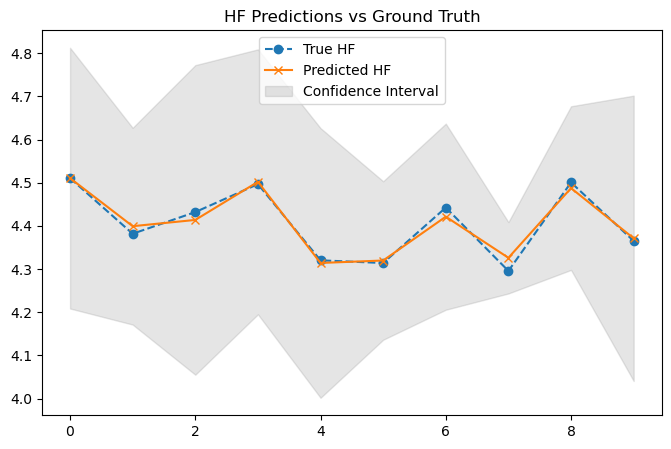

In [4]:
# 🔹 6️⃣ Compute Residuals
residuals = mean_pred.numpy() - Y_test_HF  # Shape: (10, 49)

# ✅ Print summary
print(f"🔍 Final Residuals: {residuals.mean():.4f} ± {residuals.std():.4f}")
print(f"✅ Model trained and predictions completed!")

# ✅ Check Noise Variance
print(f"🔍 Learned noise variance: {mf_gp.likelihood.variance.numpy()}")

# ✅ Evaluate Test Performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test_HF, mean_pred.numpy())
print(f"🔍 HF Prediction MSE: {mse:.4f}")

# ✅ Visualize Predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(Y_test_HF[:, 0], label="True HF", linestyle="--", marker="o")
plt.plot(mean_pred.numpy()[:, 0], label="Predicted HF", linestyle="-", marker="x")
plt.fill_between(
    np.arange(len(Y_test_HF[:, 0])),
    mean_pred.numpy()[:, 0] - 2 * np.sqrt(var_pred.numpy()[:, 0]),
    mean_pred.numpy()[:, 0] + 2 * np.sqrt(var_pred.numpy()[:, 0]),
    alpha=0.2, color="gray", label="Confidence Interval"
)
plt.legend()
plt.title("HF Predictions vs Ground Truth")
plt.show()

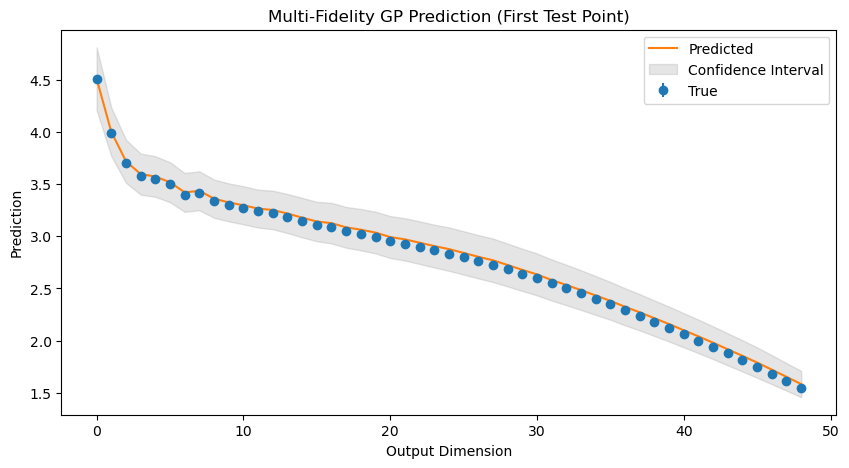

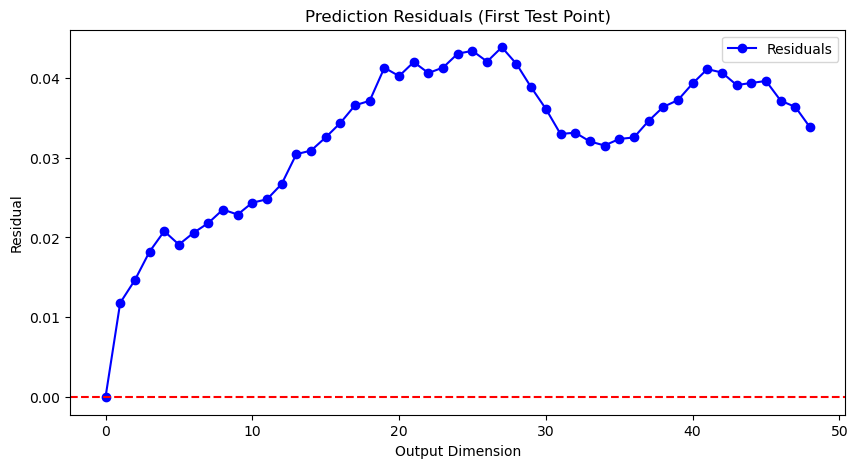

In [5]:
# 🔹 7️⃣ Plot Predictions vs Ground Truth
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.errorbar(np.arange(49), Y_test_HF[0], yerr=1e-4, fmt='o', label="True")
plt.plot(np.arange(49), mean_pred.numpy()[0], label="Predicted", color='C1')
plt.fill_between(np.arange(49), mean_pred.numpy()[0] - 2 * np.sqrt(var_pred.numpy()[0]),
                 mean_pred.numpy()[0] + 2 * np.sqrt(var_pred.numpy()[0]), alpha=0.2, color='gray', label="Confidence Interval")
plt.xlabel("Output Dimension")
plt.ylabel("Prediction")
plt.legend()
plt.title("Multi-Fidelity GP Prediction (First Test Point)")
plt.show()

# 🔹 8️⃣ Residual Plot
plt.figure(figsize=(10, 5))
plt.plot(np.arange(49), residuals[0], 'bo-', label="Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Output Dimension")
plt.ylabel("Residual")
plt.legend()
plt.title("Prediction Residuals (First Test Point)")
plt.show()

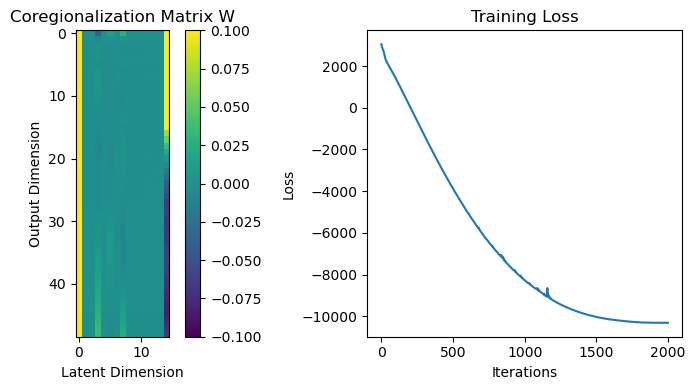

In [6]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
im = ax[0].imshow(mf_gp.kernel.W.numpy(), aspect='auto', cmap='viridis', vmin=-.1, vmax=.1)
fig.colorbar(im, ax=ax[0], orientation='vertical')
ax[0].set_aspect('equal')
ax[0].set_title("Coregionalization Matrix W")
ax[0].set_xlabel("Latent Dimension")
ax[0].set_ylabel("Output Dimension")
ax[1].plot(mf_gp.loss_history)
ax[1].set_title("Training Loss")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Loss")
fig.tight_layout()
